In [63]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import scipy
import math

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

from catboost import Pool, CatBoostClassifier
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
import re
from nltk.tokenize import word_tokenize
import gensim
import string

plt.style.use('ggplot')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
train = pd.read_csv('train_spam.csv')
test = pd.read_csv('test_spam.csv')

## Разведывательный анализ данных

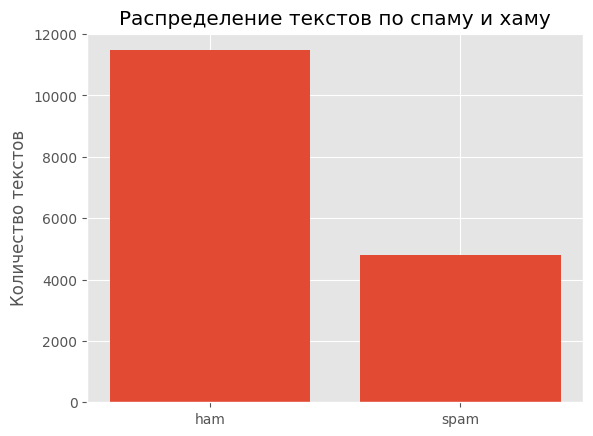

In [65]:
x=train['text_type'].value_counts()
plt.bar(x.index, x)
plt.ylabel('Количество текстов')
plt.title('Распределение текстов по спаму и хаму')
plt.show()

In [66]:
def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)

    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

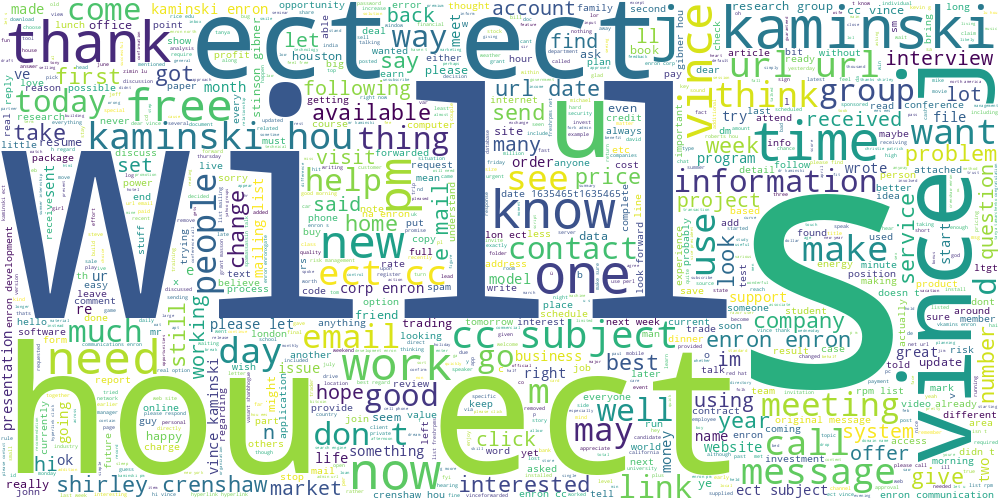

In [67]:
## Наиболее частые слова в текстах обучающей выборки
draw_wordcloud(train['text'])

In [68]:
target = {'spam': 1, 'ham': 0}
train['target'] = train['text_type'].apply(lambda x: target[x])

## Обучение моделей

### Sklearn

In [69]:
X = train['text']
y = train['target']

# Разделяем исходную обучающую выборку на обучающую и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF векторизация
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

# Инициализация моделей
lr_model = LogisticRegression()
rf_model = RandomForestClassifier()
gb_model = GradientBoostingClassifier()

In [70]:
lr_model.fit(X_train_vec, y_train)
rf_model.fit(X_train_vec, y_train)
gb_model.fit(X_train_vec, y_train)

lr_preds = lr_model.predict_proba(X_val_vec)[:, 1]
rf_preds = rf_model.predict_proba(X_val_vec)[:, 1]
gb_preds = gb_model.predict_proba(X_val_vec)[:, 1]

### CatBoost

In [71]:
ham, spam = np.bincount(train['target'])

total = ham + spam

weight_for_ham = total / ham
weight_for_spam = total / spam

class_weight = {0: weight_for_ham, 1: weight_for_spam}

print('Weight for ham: {:.2f}'.format(weight_for_ham))
print('Weight for spam: {:.2f}'.format(weight_for_spam))

Weight for ham: 1.42
Weight for spam: 3.38


In [72]:
model = CatBoostClassifier(text_features=['text'])

parameters = {'learning_rate': [0.01, 0.05, 0.1],
              'depth': [3, 5, 7, 10],
              'iterations': [10, 50, 100, 300]
              }
grid_search_result = model.grid_search(parameters,
                                       X=pd.DataFrame(X_train),
                                       y=pd.DataFrame(y_train),
                                       cv=3)

Выходные данные были обрезаны до нескольких последних строк (5000).
26:	learn: 0.6560781	test: 0.6584440	best: 0.6584440 (26)	total: 111ms	remaining: 299ms
27:	learn: 0.6550639	test: 0.6575067	best: 0.6575067 (27)	total: 117ms	remaining: 300ms
28:	learn: 0.6540683	test: 0.6565895	best: 0.6565895 (28)	total: 120ms	remaining: 293ms
29:	learn: 0.6531078	test: 0.6556919	best: 0.6556919 (29)	total: 130ms	remaining: 304ms
30:	learn: 0.6521502	test: 0.6548136	best: 0.6548136 (30)	total: 136ms	remaining: 304ms
31:	learn: 0.6512187	test: 0.6539541	best: 0.6539541 (31)	total: 140ms	remaining: 297ms
32:	learn: 0.6503152	test: 0.6531131	best: 0.6531131 (32)	total: 146ms	remaining: 296ms
33:	learn: 0.6494212	test: 0.6522901	best: 0.6522901 (33)	total: 150ms	remaining: 290ms
34:	learn: 0.6485464	test: 0.6514848	best: 0.6514848 (34)	total: 153ms	remaining: 285ms
35:	learn: 0.6476869	test: 0.6506968	best: 0.6506968 (35)	total: 157ms	remaining: 279ms
36:	learn: 0.6468487	test: 0.6499257	best: 0.6499257

In [73]:
catboost_params = {
    'iterations': grid_search_result['params']['iterations'],
    'learning_rate': grid_search_result['params']['learning_rate'],
    'depth': grid_search_result['params']['depth'],
    'eval_metric': 'AUC',
    'verbose': 50
}

model = CatBoostClassifier(**catboost_params, class_weights=class_weight)
model.fit(pd.DataFrame(X_train), pd.DataFrame(y_train), text_features=['text'])

catboost_preds = model.predict_proba(pd.DataFrame(X_val))[:, 1]
catboost_roc_auc = roc_auc_score(y_val, catboost_preds)

0:	total: 49.9ms	remaining: 14.9s
50:	total: 2.07s	remaining: 10.1s
100:	total: 3.88s	remaining: 7.64s
150:	total: 5.67s	remaining: 5.6s
200:	total: 7.46s	remaining: 3.67s
250:	total: 9.21s	remaining: 1.8s
299:	total: 11.2s	remaining: 0us


## Нейросеть (BERT) ((реализовать не получилось))

In [74]:
from datasets import Dataset
df_train, df_val = train_test_split(train, test_size=0.2)

In [75]:
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)

In [76]:
from transformers import AutoTokenizer

In [77]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [78]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/13022 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [79]:
tokenized_val = val_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/3256 [00:00<?, ? examples/s]

In [80]:
from transformers import AutoModelForSequenceClassification

In [81]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [82]:
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate

In [83]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [84]:
metric = evaluate.load("roc_auc")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [85]:
trainer = Trainer(
    model=model,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

## Тестирование моделей и выбор лучшей

In [86]:
# Calculate ROC-AUC scores
lr_roc_auc = roc_auc_score(y_val, lr_preds)
rf_roc_auc = roc_auc_score(y_val, rf_preds)
gb_roc_auc = roc_auc_score(y_val, gb_preds)

print(f"Logistic Regression ROC-AUC: {lr_roc_auc}")
print(f"Random Forest ROC-AUC: {rf_roc_auc}")
print(f"Gradient Boosting ROC-AUC: {gb_roc_auc}")

print(f"CatBoost ROC-AUC: {catboost_roc_auc}")

Logistic Regression ROC-AUC: 0.9788047748181564
Random Forest ROC-AUC: 0.985539378886567
Gradient Boosting ROC-AUC: 0.9473419856368384
CatBoost ROC-AUC: 0.9790547592661285


## Результат

In [87]:
test_transformed = vectorizer.transform(test['text'])
rf_preds_test = rf_model.predict_proba(test_transformed)[:, 1]

In [88]:
test['score'] = rf_preds_test

In [90]:
test.to_csv('task_result.csv', index=False)